In [1]:
import ipyparallel as ipp

# c = ipp.Client()

# c.ids


# c[:].apply_sync(lambda : "Hello, World")


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)


In [63]:

methodName='std_300'#'frontier_points_corner'#'frontier_points_corner'#

############################
# simulation temperature
T=300.0
# target temperature
T_target=300.0

if methodName=='std_300':
    addReference=0
else:
    addReference=1

dataName='TemporaryData_T500K'
folderName='/Users/zofia/github/DFM/'


modelName='Dimer'

finalLength = 30000
modnr = 10#1000

colective_variable = helpers.compute_radius
cv_name = 'Radius'

# results from this code will be saved here:
simulationFolder='/Users/zofia/github/DFM/TemporaryFigures/'+modelName+'/'+methodName

# load results from reference simulation already postprocessed

reference_folder = '/Users/zofia/github/DFM/TemporaryFigures/'+modelName+'/std_300'

### reference at 300K
# Raw:
# <Radius> = Quantity(value=1.7522397, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5599391188475216, unit=angstrom)
# Raw:
# <E> = Quantity(value=4.8909900846302508, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.1952283576218186, unit=kilojoule/mole)
# ->3.46 :)
#t 500:
# Raw:
# <Radius> = Quantity(value=2.1970608, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5851064100553285, unit=angstrom)
# Raw:
# <E> = Quantity(value=8.2463439643144607, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.6909848345915366, unit=kilojoule/mole)
# ############################




In [50]:
mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)





temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')

# this will be used only to compare the target distributions
integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)


Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)
angstrom
System has 2 particle(s)
1043.16864164 K
518.230768646 K


Loaded trajectory of length 100000


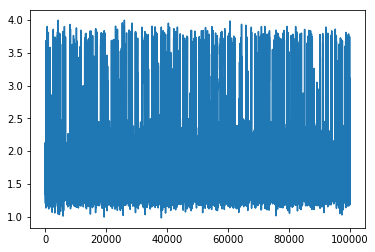

In [51]:
X_FT = helpers.loadData(folderName+dataName+'/'+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology, modnr)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

Get the target density at sampled data points
... might take a while ...
Done
Done


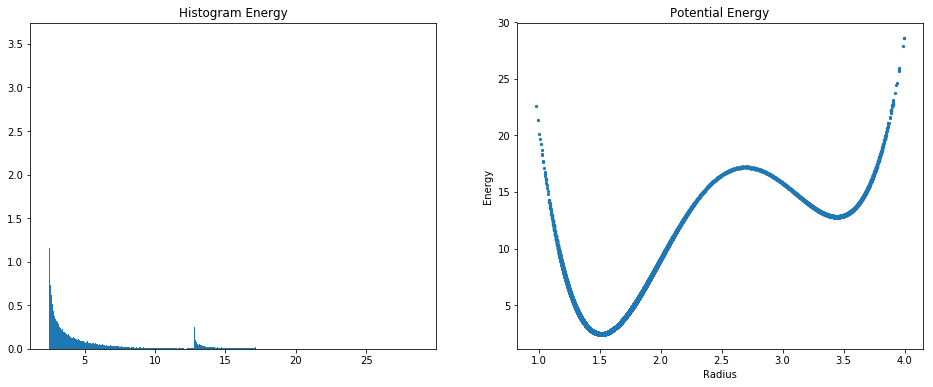

In [52]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [53]:

#### define rmsd metric


def myRMSDmetricPrecentered(arr1, arr2):
    """
    This is built under the assumption that the space dimension is 3!!!
    Requirement from sklearn radius_neighbors_graph: The callable should take two arrays as input and return one value indicating the distance between them.
     Input: One row from reshaped xyz trajectory as number of steps times nDOF
     Inside: Reshape back to md.Trajectory and apply md.rmsd as r=md.rmsd(X[i], X[j])
     Output: r
    """


    nParticles = len(arr1) / 3;
    assert (nParticles == int(nParticles))

    arr1 = arr1.reshape(int(nParticles), 3 )
    arr2 = arr2.reshape(int(nParticles), 3 )


    p1MD=md.Trajectory(arr1, mdl.testsystem.topology)
    p2MD=md.Trajectory(arr2,  mdl.testsystem.topology)

    d=md.rmsd(p1MD, p2MD)#, precentered=True, parallel=True)

    return d

import scipy.sparse as sps

def computeRMSDdistances(X_mdtraj, cutoff):
    """
    Parameters
    ----------
    X : mdtraj trajectory
    
    Returns
    -------
    S : csr.matrix of distances
    """
    
    distances = np.zeros((X_mdtraj.n_frames, X_mdtraj.n_frames))
    for i in range(X_mdtraj.n_frames):
        for j in range(i, X_mdtraj.n_frames):
            dist =md.rmsd(X_mdtraj[i], X_mdtraj[j])
            if dist < cutoff:
               
                distances[j,i] = dist
              
    return sps.csr_matrix(distances)
   

# def computeRMSDdistances(X_mdtraj):
#     """
#     Parameters
#     ----------
#     X : mdtraj trajectory
    
#     Returns
#     -------
#     S : (TBD csr.)matrix of distances
#     """
    
#     distances = np.empty((X_mdtraj.n_frames, X_mdtraj.n_frames))
#     for i in range(X_mdtraj.n_frames):
#         distances[i] =md.rmsd(X_mdtraj, X_mdtraj, i)

#     return distances



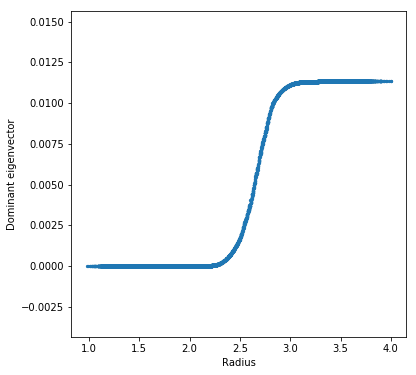

In [54]:
import scipy.sparse as sps

traj = md.Trajectory(X_FT, mdl.testsystem.topology)

indptr = [0]
indices = []
data = []
k = 1000
epsilon = 0.0001

for i in range(traj.n_frames):
    # compute distances to frame i
    distances = md.rmsd(traj, traj, i)
    # this performs a partial sort so that idx[:k] are the indices of the k smallest elements
    idx = np.argpartition(distances, k)
    # retrieve corresponding k smallest distances
    distances = distances[idx[:k]]
    # append to data structure
    data.extend(np.exp(-1.0/epsilon*distances**2).tolist())
    indices.extend(idx[:k].tolist())
    indptr.append(len(indices))

kernel_matrix = sps.csr_matrix((data, indices, indptr), dtype=float, shape=(traj.n_frames, traj.n_frames))

# this is all stolen from pydiffmap
weights_tmdmap = qTargetDistribution

alpha = 1.0
q = np.array(kernel_matrix.sum(axis=1)).ravel()
# Apply right normalization
right_norm_vec = np.power(q, -alpha)
if weights_tmdmap is not None:
    right_norm_vec *= np.sqrt(weights_tmdmap)

m = right_norm_vec.shape[0]
Dalpha = sps.spdiags(right_norm_vec, 0, m, m)
kernel_matrix = kernel_matrix * Dalpha

# Perform  row (or left) normalization
row_sum = kernel_matrix.sum(axis=1).transpose()
n = row_sum.shape[1]
Dalpha = sps.spdiags(np.power(row_sum, -1), 0, n, n)
P = Dalpha * kernel_matrix

n_evecs = 2

evals, evecs = spsl.eigs(P, k=(n_evecs+1), which='LM')
ix = evals.argsort()[::-1][1:]
evals = np.real(evals[ix])
evecs = np.real(evecs[:, ix])
dmap = np.dot(evecs, np.diag(evals))

[evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
phi = np.real(evecsT.ravel())

fig = plt.figure(figsize=(6,6))
plt.scatter(cv, evecs[:,0], s=5)
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')
plt.show()

In [33]:
# import time


# start = time.clock() 

# D = computeRMSD_sparse(X_mdtraj,100)
# elapsed = time.clock()
# elapsed = elapsed - start

# print(elapsed)

In [35]:
# ################ diffusion diffmaps

# epsilon=0.01

# Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

# mydmap = dmpy.DiffusionMap(alpha = 1, n_evecs = 1, epsilon = epsilon,  k=1000, metric='precomputed')#, neighbor_params = {'n_jobs':-4})
# dmap = mydmap.fit_transform(Xresh, weights =qTargetDistribution_targetTemperature)

# P = mydmap.P
# evals = mydmap.evals
# evecs = mydmap.evecs

# [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
# phi = np.real(evecsT.ravel())



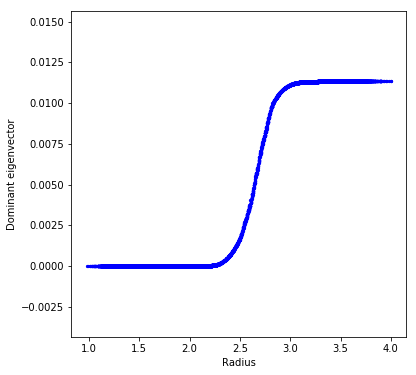

In [64]:


if addReference:
    evecs_ref = np.load(reference_folder+'/dominant_eigenvector_300.npy')
    cv_ref = np.load(reference_folder+'/cv_eigenvector_300.npy')
    
else:
        
    np.save(reference_folder+'/dominant_eigenvector_300.npy', evecs)
    np.save(reference_folder+'/cv_eigenvector_300.npy', cv)



fig = plt.figure(figsize=(6,6))
plt.scatter(cv,  evecs[:,0], s=5, c='b')
if addReference:
    plt.scatter(cv_ref, evecs_ref[:,0], s=5, c='r')
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')
if addReference:
    plt.legend(['Eigenvector','Ref'])

fig.savefig(simulationFolder+'/dominant_eigenvector.png')
plt.show()




#####


In [65]:

# estimated density by KDE
q_est = q*phi#*mydmap.q
q_estNormalized = q_est/sum(q_est)

qTargetDistributionNormalized = qTargetDistribution/sum(qTargetDistribution)
print("Error on the density: "+repr(np.linalg.norm(q_estNormalized - qTargetDistributionNormalized,1)))

## compute weights w.r.t. taget density 

weight = qTargetDistribution_targetTemperature/q#(mydmap.q)
qTargetDistributionNormalized_targetTemperature=qTargetDistribution_targetTemperature/np.sum(qTargetDistribution_targetTemperature)

print('Sum weights is '+repr(np.sum(weight)))
print('mean weight is '+repr(np.mean(weight)))
print('sum weight is '+repr(np.sum(weight)))
print('max weight is '+repr(np.max(weight)))
print('min weight is '+repr(np.min(weight)))
print('Max error is '+repr(np.max(np.abs(qTargetDistributionNormalized-q_estNormalized))))
print('Mean error is '+repr(np.mean(np.abs(qTargetDistributionNormalized-q_estNormalized))))



Error on the density: 0.31545704067477442
Sum weights is 227.33984863872209
mean weight is 0.0022733984863872207
sum weight is 227.33984863872209
max weight is 0.0037428753292839938
min weight is 2.0678208380913867e-06
Max error is 3.8712579568137682e-05
Mean error is 3.1545704067477444e-06


In [ ]:
# compare estimated and target density (not actual density !!!)
if addReference:
    q_estNormalized_ref = np.load(reference_folder+'/density_300K.npy')
    qTargetDistributionNormalized_ref = np.load(reference_folder+'/kde_300K.npy')
    cv_ref = np.load(reference_folder+'/cv_300K.npy')
    
else:
        np.save(reference_folder+'/density_300K.npy',  (qTargetDistributionNormalized_targetTemperature))
        np.save(reference_folder+'/kde_300K.npy',  (q_estNormalized))
        np.save(reference_folder+'/cv_300K.npy',  cv)





### plot densities and weights


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(cv, -np.log(q_estNormalized), s=5, c='r')
ax.scatter(cv, -np.log(qTargetDistributionNormalized_targetTemperature), s=5, c='b')
if addReference:
    ax.scatter(cv_ref, -np.log(q_estNormalized_ref), s=5, c='g')
    ax.scatter(cv_ref, -np.log(qTargetDistributionNormalized_ref), s=5, c='k')
    ax.legend(['KDE 500K','Target 500K', 'KDE 300K', 'Target 300K'])
else:
    ax.legend(['KDE T=','Target'])
ax.set_xlabel('Radius')
ax.set_ylabel('Density')


ax.set_title('Densities')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), weight  ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Weight')
#ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/KDE_weight.png')


plt.show()


In [ ]:

##### compute Averages

observable=cv

meanR=np.mean(observable)
meanRunbiased=np.mean(observable*weight)/np.mean(weight)

print('Raw:')
print('<'+cv_name+'> = '+repr(meanR*smpl.model.x_unit))

print('\nUnbiased:')
print('<'+cv_name+'> = '+repr(meanRunbiased*smpl.model.x_unit))

#compute mean energy

meanE=np.mean(E)
meanEunbiased=np.mean(E*weight)/np.mean(weight)

print('Raw:')
print('<E> = '+repr(meanE*smpl.model.energy_unit))

print('\nUnbiased:')
print('<E> = '+repr(meanEunbiased*smpl.model.energy_unit))

##############


Raw:
<Radius> = Quantity(value=1.7491392, unit=angstrom)

Unbiased:
<Radius> = Quantity(value=1.5561377122815536, unit=angstrom)
Raw:
<E> = Quantity(value=4.8832103136849403, unit=kilojoule/mole)

Unbiased:
<E> = Quantity(value=3.16695558561806, unit=kilojoule/mole)


In [ ]:
import imp
imp.reload(helpers)

width=0.1
cv=colective_variable(X_FT)


free_energy_raw=helpers.compute_free_energy(X_FT, cv, width=width, kBT=smpl_target.kT)
free_energy_unbiased=helpers.compute_free_energy(X_FT, cv, width=width, weights=weight, kBT=smpl_target.kT)

if(addReference):
    free_energy_raw_ref = np.load(reference_folder+'/free_energy_raw_ref.npy')
    free_energy_unbiased_ref = np.load(reference_folder+'/free_energy_unbiased_ref.npy')
    cv_ref = np.load(reference_folder+'/cv_for_free_energy_ref.npy')
else:

    np.save(reference_folder+'/free_energy_raw_ref', free_energy_raw)
    np.save(reference_folder+'/free_energy_unbiased_ref', free_energy_unbiased)
    np.save(reference_folder+'/cv_for_free_energy_ref', cv)





fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(cv, free_energy_raw, s=5, c='r')
ax.scatter(cv, free_energy_unbiased, s=5, c='b')
if(addReference):
    ax.scatter(cv_ref, free_energy_raw_ref, s=5, c='g')
    ax.scatter(cv_ref, free_energy_unbiased_ref, s=5, c='k')
ax.set_xlabel(cv_name)
ax.set_ylabel('free energy [kBT]')
if(addReference):
    ax.legend(['Raw','Unbiased', 'Ref raw', 'Ref unbiased'])
else:
    ax.legend(['Raw','Unbiased'])
ax.set_title('Free energy: '+repr(modelName))

fig.savefig(simulationFolder+'/free_energy.png')
plt.show()